In [1]:
import handcalcs.render
from ctypes import *
from numpy.ctypeslib import ndpointer
from typing import Union
import matplotlib.pyplot as plt
from random import randint
import timeit

In [10]:
%load_ext Cython

$$\begin{align}\beta _{i}^{{(0)}}:=\beta _{i}{\mbox{ , }}i=0,\ldots ,n\end{align}$$
$$\begin{align}\beta _{i}^{{(j)}}:=\beta _{i}^{{(j-1)}}(1-t_{0})+\beta _{{i+1}}^{{(j-1)}}t_{0}{\mbox{ , }}i=0,\ldots ,n-j{\mbox{ , }}j=1,\ldots ,n\end{align}$$

In [11]:
def B_py(arr: list, i: int, j: int, t: float) -> float:
    """
    Python Implementation
    Using De Casteljau's algorithm:
    Gets the one dimensional value of the coords at the provided i value
    Recurrence relation:
        B(i, j) = B(i, j - 1) * (1 - t) + B(i + 1, j - 1) * t
    """
    return arr[i] if j == 0 else B_py(arr, i, j - 1, t) * (1 - t) + B_py(arr, i + 1, j - 1, t) * t

In [12]:
%%cython
def B_cy(list arr, int i, int j, float t) -> float:
    """
    Cython Implementation
    Using De Casteljau's algorithm:
    Gets the one dimensional value of the coords at the provided i value
    Recurrence relation:
        B(i, j) = B(i, j - 1) * (1 - t) + B(i + 1, j - 1) * t
    """
    return arr[i] if j == 0 else B_cy(arr, i, j - 1, t) * (1 - t) + B_cy(arr, i + 1, j - 1, t) * t

C code (compiled to bezier.dll):

`gcc -c bezier.c`

`gcc -shared -o bezier.dll bezier.o`

NUMBER_OF_POINTS can be changed by compiling with `gcc bezier.c -DNUMBER_OF_POINTS=n` where the int n = new NUMBER_OF_POINTS

```c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#define len(x)  (sizeof(x) / sizeof((x)[0]))

#ifndef NUMBER_OF_POINTS
#define NUMBER_OF_POINTS 1000
#endif

double B(int *arr, int i, int j, double t){
    if(j == 0){
        return arr[i];
    }else{
        return B(arr, i, j - 1, t) * (1 - t) + B(arr, i + 1, j - 1, t) * t;
    }
}

double * get_x(int *control_x, int num_of_control){
    int n = num_of_control;

    static double x_points[NUMBER_OF_POINTS];
    for(int t = 0; t < NUMBER_OF_POINTS; t++){
        x_points[t] = B(control_x, 0, n - 1, ((double)t)/((double)NUMBER_OF_POINTS));
    }
    return x_points;
}

double * get_y(int *control_y, int num_of_control){
    int n = num_of_control;

    static double y_points[1000];
    for(int t = 0; t < NUMBER_OF_POINTS; t++){
        y_points[t] = B(control_y, 0, n - 1, ((double)t)/((double)NUMBER_OF_POINTS));
    }
    return y_points;
}
```

In [19]:
def get_points(cx: list, cy: list, nop: int, B: Union[B_py, B_cy]) -> tuple:
    """
    Gets points along the bezier curve using the control points
    :param cx: Control points x coords
    :param cy: Control points y coords
    :param nop: Number of points to calculate
    :param B: Chosen implementation of B to use
    :return: tuple of all x and y coords such that (x[n], y[n]) -> point on curve
    """
    n = len(cx)
    x = [B(cx, 0, n - 1, t/nop) for t in range(nop)]
    y = [B(cy, 0, n - 1, t/nop) for t in range(nop)]
    return x, y


def get_points_c(cx: list, cy: list, nop: int) -> tuple:
    bezier = CDLL("bezier.dll")
    
    bezier.get_x.argtypes = [POINTER(c_int), c_int]
    bezier.get_y.argtypes = [POINTER(c_int), c_int]
    
    x_arr_point = (c_int * len(cx))(*cx)
    y_arr_point = (c_int * len(cy))(*cy)
    
    bezier.get_x.restype = ndpointer(dtype=c_double, shape=(nop,))
    bezier.get_y.restype = ndpointer(dtype=c_double, shape=(nop,))
    
    n = len(cx)
    x = bezier.get_x(x_arr_point, n)
    y = bezier.get_y(y_arr_point, n)
    return x, y

In [6]:
%timeit get_points([1, 10, 14, 8], [5, 15, 3, 5], 1000, B_py)
%timeit get_points([1, 10, 14, 8], [5, 15, 3, 5], 1000, B_cy)
%timeit get_points_c([1, 10, 14, 8], [5, 15, 3, 5], 1000)

5.41 ms ± 536 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
129 µs ± 3.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [27]:
def exec_times():
    py_times = []
    cy_times = []
    c_times = []

    for i in range(10):
        cnx = [randint(0, 100) for _ in range(i + 1)]
        cny = [randint(0, 100) for _ in range(i + 1)]
        
        py = timeit.timeit(f"get_points({cnx}, {cny}, 1000, B_py)", globals=globals(), number=10)
        cy = timeit.timeit(f"get_points({cnx}, {cny}, 1000, B_cy)", globals=globals(), number=10)
        c = timeit.timeit(f"get_points_c({cnx}, {cny}, 1000)", globals=globals(), number=10)
        
        py_times.append(py)
        cy_times.append(cy)
        c_times.append(c)
        
        print(i, end="")
    
    return py_times, cy_times, c_times

<IPython.core.display.Javascript object>


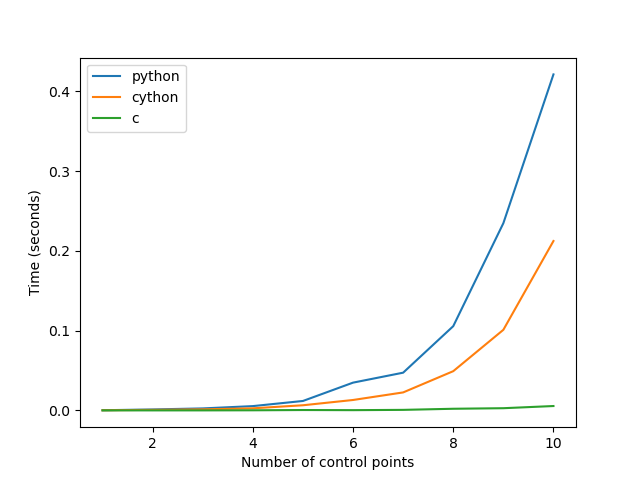

0123456789

In [31]:
%matplotlib notebook

fig = plt.figure()
ax = plt.subplot(111)

x_axis = [(i + 1) for i in range(10)]

pyt, cyt, ct = exec_times()

pyt = [i/10 for i in pyt]
cyt = [i/10 for i in cyt]
ct = [i/10 for i in ct]

ax.plot(x_axis, pyt, label="python")
ax.plot(x_axis, cyt, label="cython")
ax.plot(x_axis, ct, label="c")
ax.set_xlabel("Number of control points")
ax.set_ylabel("Time (seconds)")

plt.legend(loc="upper left")
plt.show()

<IPython.core.display.Javascript object>


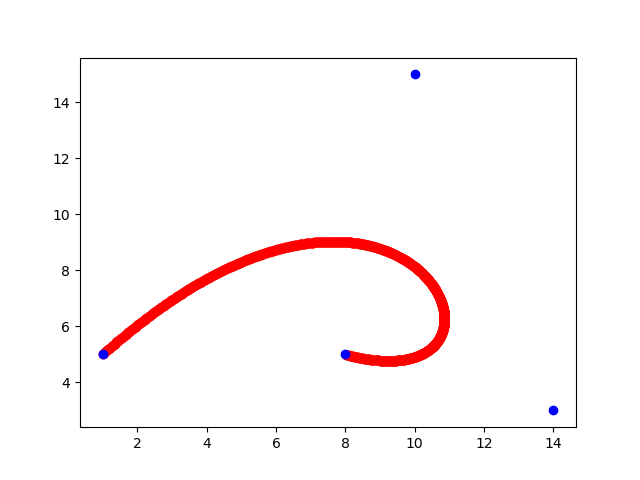

In [7]:
%matplotlib notebook

control_x = [1, 10, 14, 8]
control_y = [5, 15, 3, 5]

number_of_points = 1000

x_points, y_points = get_points_c(control_x, control_y, number_of_points)

fig = plt.figure()
ax = plt.subplot(111)

for x, y in zip(x_points, y_points):
    plt.plot(x, y, marker="o", color="red")

for cx, cy in zip(control_x, control_y):
    plt.plot(cx, cy, marker="o", color="blue")

plt.show()